✅ Usando dispositivo: cpu


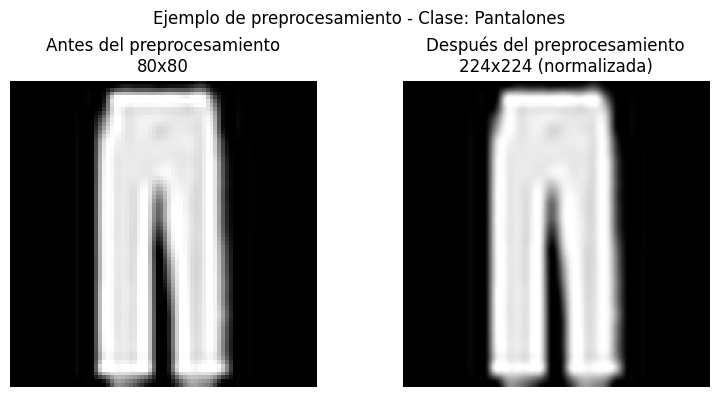

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.82].


Rango de valores normalizados:
mínimo=0.000, máximo=1.000
✅ Dataset cargado: 70 imágenes
✅ Train set: 56 | Test set: 14


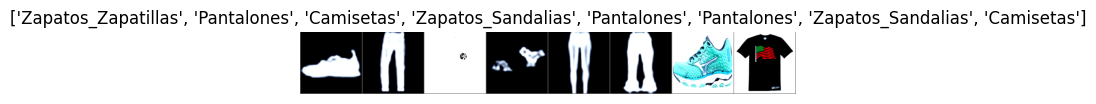

In [36]:
# --- 1. Librerías necesarias ---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

import torchvision

# Verificar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Usando dispositivo:", device)

# --- 2. Preprocesamiento: redimensionar, normalizar y visualizar ---

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import random

# Ruta de tu dataset generado con data.py
dataset_path = "./mini_dataset_80x80_imagenes"

# Elegir aleatoriamente una subcarpeta y una imagen
carpeta = random.choice(os.listdir(dataset_path))
imagen_path = os.path.join(dataset_path, carpeta, random.choice(os.listdir(os.path.join(dataset_path, carpeta))))

# Cargar imagen original (80x80)
imagen_original = Image.open(imagen_path).convert("RGB")

# --- Preprocesamiento ---
# 1️⃣ Redimensionar a 224x224 píxeles
imagen_redimensionada = imagen_original.resize((224, 224))

# 2️⃣ Normalizar los píxeles al rango [0,1]
imagen_normalizada = np.asarray(imagen_redimensionada) / 255.0  # convertir a array y escalar

# --- Visualización: antes y después ---
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Imagen original
axes[0].imshow(imagen_original)
axes[0].set_title(f"Antes del preprocesamiento\n{imagen_original.size[0]}x{imagen_original.size[1]}")
axes[0].axis("off")

# Imagen preprocesada
axes[1].imshow(imagen_normalizada)
axes[1].set_title("Después del preprocesamiento\n224x224 (normalizada)")
axes[1].axis("off")

plt.suptitle(f"Ejemplo de preprocesamiento - Clase: {carpeta}", fontsize=12)
plt.tight_layout()
plt.show()

# Mostrar rango de valores como verificación
print("Rango de valores normalizados:")
print(f"mínimo={imagen_normalizada.min():.3f}, máximo={imagen_normalizada.max():.3f}")



# --- 3. Cargar dataset y crear data loaders ---
# Aplicar transformaciones
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cargar dataset
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Dividir en train y test (80-20)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Crear data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print("✅ Dataset cargado:", len(dataset), "imágenes")
print("✅ Train set:", len(train_dataset), "| Test set:", len(test_dataset))

# --- 4. Visualización de imágenes ---
def imshow(img, title=None):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# Obtener un batch de imágenes
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostrar
imshow(torchvision.utils.make_grid(images), title=[dataset.classes[l] for l in labels])



In [37]:
# --- 4. Modelo preentrenado y ajuste ---
num_classes = len(dataset.classes)

# Cargar modelo preentrenado
model = models.resnet18(pretrained=True)

# Congelar las capas convolucionales
for param in model.parameters():
    param.requires_grad = False

# Reemplazar la última capa totalmente conectada
model.fc = nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)
print("✅ Modelo preparado con", num_classes, "clases.")


✅ Modelo preparado con 5 clases.


In [38]:
# --- 5. Entrenamiento: configuración ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [39]:
import torchvision

alexnet = torchvision.models.AlexNet()
#Al escribir torchvision.models.AlexNet(), creas el modelo desde cero (sin pesos preentrenados),
#es decir, sus pesos se inicializan aleatoriamente.

alexnet
#Mostrará:
#features: las capas convolucionales.
#classifier: las capas completamente conectadas que hacen la clasificación final.


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [40]:
# --- 6. Entrenamiento ---
epochs = 5  # puedes aumentar si quieres mejor resultado
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Época [{epoch+1}/{epochs}], Pérdida promedio: {running_loss/len(train_loader):.4f}")

print("✅ Entrenamiento finalizado")


Época [1/5], Pérdida promedio: 1.4602
Época [2/5], Pérdida promedio: 1.0742
Época [3/5], Pérdida promedio: 0.8415
Época [4/5], Pérdida promedio: 0.7364
Época [5/5], Pérdida promedio: 0.5710
✅ Entrenamiento finalizado


In [41]:
# --- 7. Evaluación ---
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"🎯 Precisión en conjunto de prueba: {100 * correct / total:.2f}%")


🎯 Precisión en conjunto de prueba: 92.86%


📸 Imagen seleccionada: ./mini_dataset_80x80_imagenes\Pantalones\pantalon-tiro-alto-recto-fluido-verde-mentaKCSq.webp


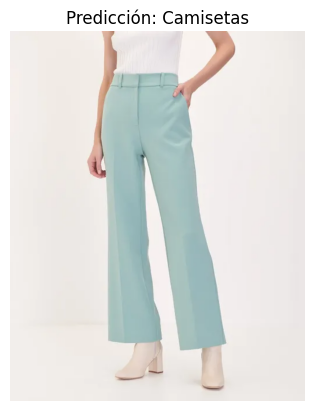

In [42]:
# --- 8. Clasificar una imagen específica ---
from random import choice

# Seleccionar aleatoriamente una imagen del dataset original
folder = choice(dataset.classes)
image_path = os.path.join(dataset_path, folder, os.listdir(os.path.join(dataset_path, folder))[0])
print("📸 Imagen seleccionada:", image_path)

# Preprocesar la imagen
img = Image.open(image_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

# Predicción
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    _, predicted = torch.max(output, 1)

pred_class = dataset.classes[predicted.item()]

# Mostrar resultado
plt.imshow(img)
plt.title(f"Predicción: {pred_class}")
plt.axis("off")
plt.show()


In [43]:
# --- 9. Guardar modelo entrenado ---
torch.save(model.state_dict(), "modelo_resnet18_fashion.pt")
print("💾 Modelo guardado correctamente.")


💾 Modelo guardado correctamente.


In [44]:
# --- 10. Cargar modelo entrenado ---
model_loaded = models.resnet18(pretrained=False)
model_loaded.fc = nn.Linear(model_loaded.fc.in_features, num_classes)
model_loaded.load_state_dict(torch.load("modelo_resnet18_fashion.pt"))
model_loaded = model_loaded.to(device)
model_loaded.eval()
print("✅ Modelo cargado correctamente para inferencia.")


✅ Modelo cargado correctamente para inferencia.


parte 2